In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
%matplotlib inline

In [3]:
experiment2_path = '/Users/yash_wani/Documents/UChicago/Research/c3ai/ENT/SpO2_hand/Experiment2.MOV' 
#RH fitted with bp cuff and spo2. recorded 4 desats over ~15 min. LH has no bp cuff. 

#first point is top left (x,y), second point is bottom right (x,y)
ROI = {'RH' : [[831,82],[1042,257]],  
       'LH' : [[831,457] ,[1017,630]],
}

gt = np.asarray([[99,0],[99,38],[98,39],[97,45],[95,65],[94,77],[95,83],[89,93],[88,100],[96,107],
[97,110],[98,121],[99,128],[99,247],[97,248],[95,254],[93,257],[92,263],[93,275],[95,283],[97,286],[98,289],
[99,305],[99,479],[97,480],[96,488],[97,491],[93,502],[90,505],[91,514],[92,520],[96,523],[98,536],[99,538],[99,729],
[96,730],[92,736],[91,740],[90,742],[93,760],[96,763],[97,766],[98,769],[99,772],[99,896]])

fs = 30
ground_truth_RH = np.zeros(gt[-1][1]*fs)
for i in range(len(gt)-1):
    start = gt[i,1]*fs
    end = gt[i+1,1]*fs
    ground_truth_RH[start:end] = gt[i,0]


In [4]:
# def extract_roi(frame, ROI_name):
#     '''
#     Take a frame, returns ROI
#     '''
#     roi = frame[ROI[ROI_name][0][1]:ROI[ROI_name][1][1], ROI[ROI_name][0][0]:ROI[ROI_name][1][0]]
#     return roi

In [5]:
# def get_channels(file):
    
#     '''
#     Inputs:
#     file - video path
#     ROI - ROI name
    
#     Returns:
#     ROI-averaged pixel intensities for r,g,b color channels
#     '''
    
#     cap = cv2.VideoCapture(file)

#     RH_b = []
#     RH_g = []
#     RH_r = []
    
#     LH_b = []
#     LH_g = []
#     LH_r = []

#     num_frames = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame = cv2.resize(frame, None, None, fx=0.68, fy=0.68)
    
            
#         roi = extract_roi(frame, 'RH')
#         if roi is None:
#             continue
#         roi_colour = roi.mean(axis=(0,1))
#         RH_b.append(roi_colour[0])
#         RH_g.append(roi_colour[1])
#         RH_r.append(roi_colour[2])
        
#         roi = extract_roi(frame, 'LH')
#         if roi is None:
#             continue
#         roi_colour = roi.mean(axis=(0,1))
#         LH_b.append(roi_colour[0])
#         LH_g.append(roi_colour[1])
#         LH_r.append(roi_colour[2])
        
        
        
#         num_frames += 1
        
#         if num_frames % 1800 == 0: #prints for every minute of frames processed
#             print(num_frames)

#     cap.release()
    
#     RH_data = [RH_r,RH_g,RH_b]
#     LH_data = [LH_r,LH_g,LH_b]
#     E2_data = [RH_data,LH_data]
    
#     return E2_data




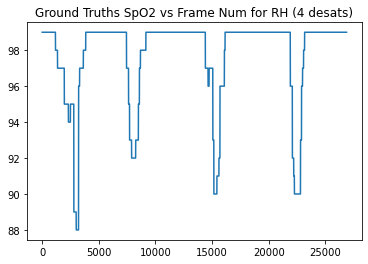

In [6]:
E2_data = np.load('E2_data.npy')
RH_data,LH_data = E2_data[0],E2_data[1]
RH_r, RH_g, RH_b = RH_data[0], RH_data[1], RH_data[2]
LH_r, LH_g, LH_b = LH_data[0], LH_data[1], LH_data[2]

#Trim signals to match ground truths
if len(ground_truth_RH) > len(RH_r):
    ground_truth_RH = ground_truth_RH[:len(RH_r)]
    
plt.plot(ground_truth_RH)
plt.title('Ground Truths SpO2 vs Frame Num for RH (4 desats)');




''' If running get_channel again, uncomment below '''
# E2_data = get_channels(experiment2_path)
# np.save('E2_data.npy', E2_data)

''' Uncomment below to display video'''
# cap= cv2.VideoCapture(experiment2_path)
# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, None, None, fx=0.68, fy=0.68)
# #     roi = extract_roi(frame, 'RH')
#     cv2.imshow('vid',frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


''' Other code ''';
# #last three seconds (90 frames) seem to have disturbance - deleting those
# RH_r, RH_g, RH_b = RH_r[:-90], RH_g[:-90], RH_b[:-90]
# LH_r, LH_g, LH_b = LH_r[:-90], LH_g[:-90], LH_b[:-90]
# #this changes are saved to E2_data.npy already

In [7]:
def butterworth_filter(data, lowcut, highcut, fs, order=5):
    '''
    band pass filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, data)

def lowpass_filter(data, cut, fs, order=5):
    '''
    low pass filter
    '''
    nyq = 0.5 * fs
    cut = cut / nyq
    b, a = signal.butter(order, cut, btype='lowpass')
    return signal.lfilter(b, a, data)

def average_filter(sig, filter_size):
    return np.convolve(sig, np.ones(filter_size)/filter_size, mode='valid') 
     

def sliding_window_demean(signal_values, num_windows):
    '''
    used for HR estimation, not currently being used
    '''
    window_size = int(round(len(signal_values) / num_windows))
    demeaned = np.zeros(signal_values.shape)
    for i in range(0, len(signal_values), window_size):
        if i + window_size > len(signal_values):
            window_size = len(signal_values) - i
    curr_slice = signal_values[i: i + window_size]
    demeaned[i:i + window_size] = curr_slice - np.mean(curr_slice)
    # demeaned[i:i + window_size] = curr_slice / np.linalg.norm(curr_slice)
    return demeaned

def AC(sig):
    '''
    calculates AC component of signal given cutoffs in https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-12-3-1746&id=448656#e6
    tinkering, so cutoffs might be slightly different
    '''
    #sig = signal.detrend(sig)
    #sig = sliding_window_demean(sig, 5)
    signal_AC = butterworth_filter(sig, 0.5, 5, 30, order=5) #cut is 0.5
    return signal_AC

def DC(sig):
    '''
    calculates DC component of signal given cutoffs in https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-12-3-1746&id=448656#e6
    tinkering, so cutoffs might be slightly different
    '''
    #sig = signal.detrend(sig)
    #sig = sliding_window_demean(sig, 5)
    signal_DC = lowpass_filter(sig, 0.2, 30, order=6)
    return signal_DC



# Right Hand Analysis - 4 Desaturation Events

## Red and Green Channel Signals

Text(0.5, 1.0, 'Avg Red Channel vs Frame no.')

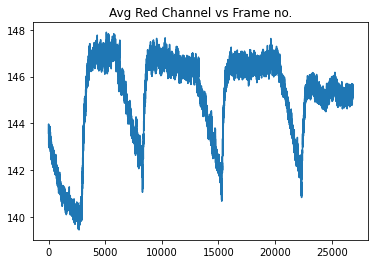

In [8]:
plt.plot(range(len(RH_r)),RH_r)
plt.title('Avg Red Channel vs Frame no.')

Text(0.5, 1.0, 'Avg Green Channel vs Frame no.')

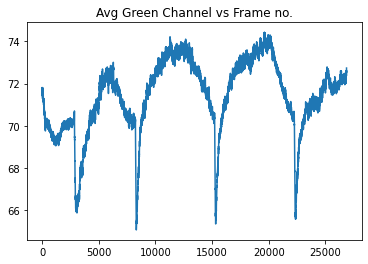

In [9]:
plt.plot(range(len(RH_g)),RH_g)
plt.title('Avg Green Channel vs Frame no.')

### Mean Subtract Signals

In [10]:
RH_r_ms = RH_r - np.mean(RH_r)
RH_g_ms = RH_g - np.mean(RH_g)

## AC Components, after mean subtraction

Text(0.5, 1.0, 'Red AC vs Frame no.')

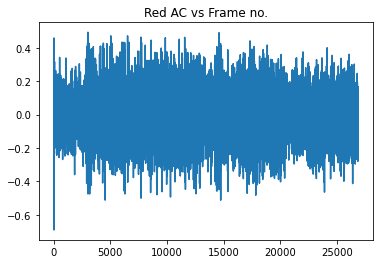

In [11]:
RH_r_AC = AC(RH_r_ms)
plt.plot(range(len(RH_r_AC)),RH_r_AC)
plt.title('Red AC vs Frame no.')

Text(0.5, 1.0, 'Green AC vs Frame no.')

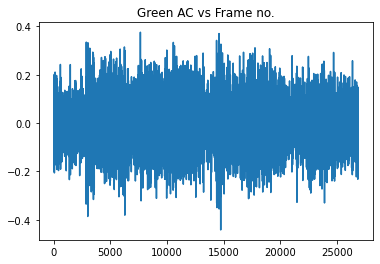

In [12]:
RH_g_AC = AC(RH_g_ms)
plt.plot(range(len(RH_g_AC)),RH_g_AC)
plt.title('Green AC vs Frame no.')

## DC Component with mean subtraction, added back

Text(0.5, 1.0, 'Red DC vs Frame no.')

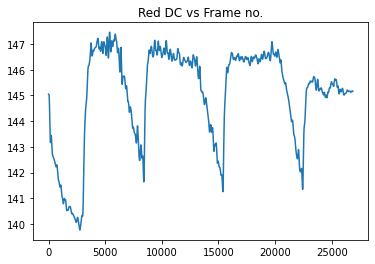

In [13]:
RH_r_DC = DC(RH_r_ms) + np.mean(RH_r)
plt.plot(range(len(RH_r_DC)),RH_r_DC)
plt.title('Red DC vs Frame no.')

Text(0.5, 1.0, 'Green DC vs Frame no.')

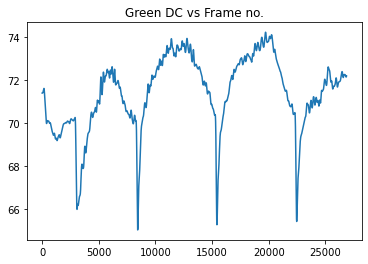

In [14]:
RH_g_DC = DC(RH_g_ms) + np.mean(RH_g)
plt.plot(range(len(RH_g_DC)),RH_g_DC)
plt.title('Green DC vs Frame no.')

## Calculate AC/DC ratio for red and green channels

Text(0.5, 1.0, 'Red AC/DC vs Frame no.')

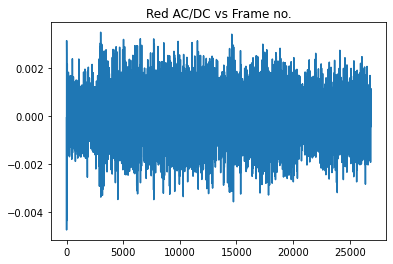

In [15]:
RH_r_AC_DC = np.divide(RH_r_AC,RH_r_DC)
#RH_r_AC_DC = np.divide(RH_r_AC,np.mean(RH_r_DC))
plt.plot(range(len(RH_r_AC_DC)),RH_r_AC_DC) 
#looks reasonable? 
np.min(np.abs(RH_r_AC)) #doesn't run into divide by zero issue here

plt.title('Red AC/DC vs Frame no.')

Text(0.5, 1.0, 'Green AC/DC vs Frame no.')

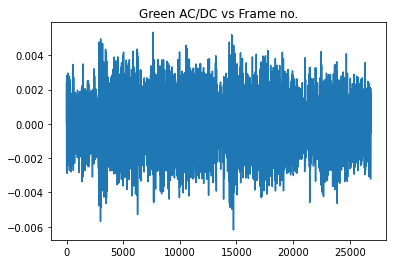

In [16]:
RH_g_AC_DC = np.divide(RH_g_AC,RH_g_DC)
#RH_g_AC_DC = np.divide(RH_g_AC,np.mean(RH_g_DC))
plt.plot(range(len(RH_g_AC_DC)),RH_g_AC_DC) 
#looks reasonable? 
np.min(np.abs(RH_g_AC)) #doesn't run into divide by zero issue here

plt.title('Green AC/DC vs Frame no.')

## Calculate Ratio of Ratios
- 1/2 second window
- 1/2 second step size

In [17]:
def process(window,step, red_channel, green_channel):
    sig_len = len(RH_r)
    num_win = sig_len//window
    
    num_win = (sig_len - window)//step + step
    
    GT = ground_truth_RH
    estimates = []
    GTs = []
    for i in range(num_win):
        r_win = red_channel[i*step:i*step+window]
        g_win = green_channel[i*step:i*step+window]
        
        GTs.append(np.mean(GT[i*step:i*step+window]))
        
    
        r_ms = r_win - np.mean(r_win)
        g_ms = g_win - np.mean(g_win)

        r_AC = AC(r_ms)
        g_AC = AC(g_ms)

        r_DC = DC(r_ms) + np.mean(r_win)
        g_DC = DC(g_ms) + np.mean(g_win)

        r_AC_DC = np.divide(r_AC,r_DC)
        g_AC_DC = np.divide(g_AC,g_DC)
        
#         RH_r_AC_DC = np.divide(RH_r_AC,1)
#         RH_g_AC_DC = np.divide(RH_g_AC,1)

        ror = np.divide(r_AC_DC+1,g_AC_DC+1)

        def local_DC(sig):
            return lowpass_filter(sig, 0.06, 30, order=3) #lowpass here

        estimate = local_DC(ror-np.mean(ror))
        estimates.append(np.mean(estimate))
        
        
#         estimates.append(np.mean(RH_ror))
    return estimates, GTs
    
    
    



//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


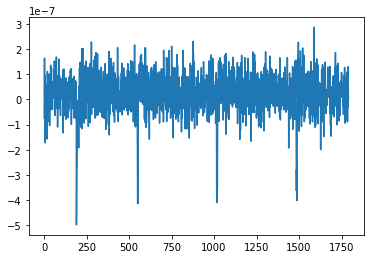

In [18]:
estimate_RH,GTs = process(15,15, RH_r, RH_g)
plt.plot(estimate_RH)


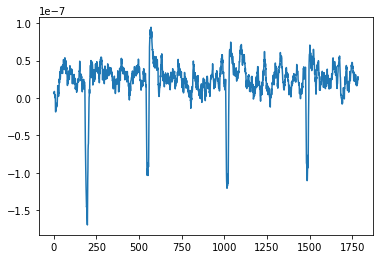

In [19]:
#Moving average the signal with 15 frame window
estimate_RH_avg = scipy.signal.convolve(estimate_RH,np.ones(15)/15,'same')
plt.plot(estimate_RH_avg)

## Fit ratio of ratios estimate using ground truths

In [20]:
#replace with some sort of cehck for NaNs
#find NaNs and delete indices from both signals
#brute forcing it here
GTs_cut = GTs[:-20]
estimates_RH_cut = np.asarray(estimate_RH_avg[:-20])
#estimates_cut_LH = np.asarray(estimates_LH[:-14])

In [21]:
def fitting(estimate, GT, order):

    n = order #polynomial order
    coef= np.polyfit(estimate,GT,n)
    fit_estimate = 0
    for i in range(n+1):
        fit_estimate = fit_estimate + coef[i]*np.power(estimate,n-i)
    return fit_estimate

In [22]:
fit_estimate_RH = fitting(estimates_RH_cut, GTs_cut, 1)

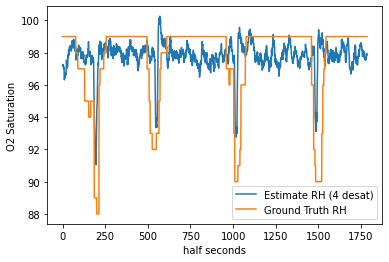

In [23]:
plt.plot(fit_estimate_RH)
plt.plot(GTs_cut)


plt.xlabel('half seconds')
plt.ylabel('O2 Saturation')
plt.legend(['Estimate RH (4 desat)','Ground Truth RH'])

# Do the whole process for left hand (no desaturation events):

Text(0.5, 1.0, 'Avg Red Channel vs Frame no.')

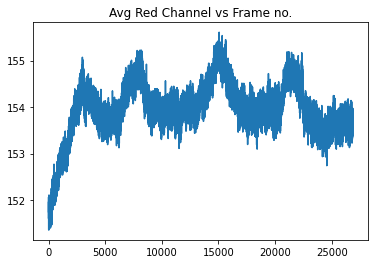

In [24]:
plt.plot(range(len(LH_r)),LH_r)
plt.title('Avg Red Channel vs Frame no.')

Text(0.5, 1.0, 'Avg Green Channel vs Frame no.')

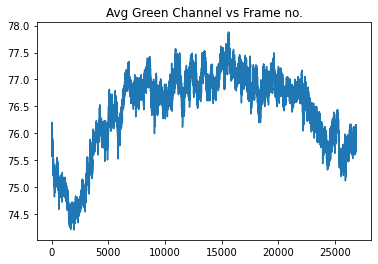

In [25]:
plt.plot(range(len(LH_g)),LH_g)
plt.title('Avg Green Channel vs Frame no.')

In [26]:
LH_r_ms = LH_r - np.mean(LH_r)
LH_g_ms = LH_g - np.mean(LH_g)

Text(0.5, 1.0, 'Red AC vs Frame no.')

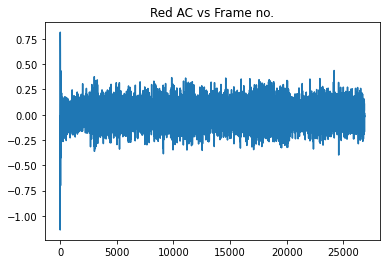

In [27]:
LH_r_AC = AC(LH_r_ms)
plt.plot(range(len(LH_r_AC)),LH_r_AC)
plt.title('Red AC vs Frame no.')

Text(0.5, 1.0, 'Green AC vs Frame no.')

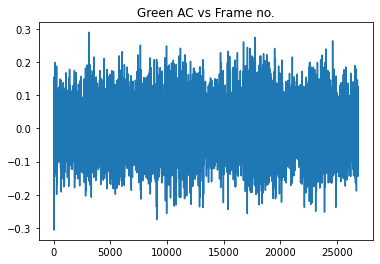

In [28]:
LH_g_AC = AC(LH_g_ms)
plt.plot(range(len(LH_g_AC)),LH_g_AC)
plt.title('Green AC vs Frame no.')

Text(0.5, 1.0, 'Red DC vs Frame no.')

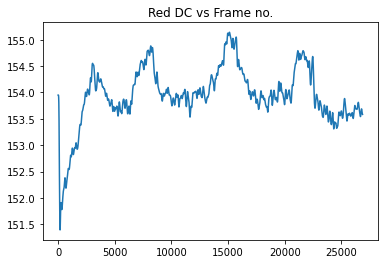

In [29]:
LH_r_DC = DC(LH_r_ms) + np.mean(LH_r)
plt.plot(range(len(LH_r_DC)),LH_r_DC)
plt.title('Red DC vs Frame no.')

Text(0.5, 1.0, 'Green DC vs Frame no.')

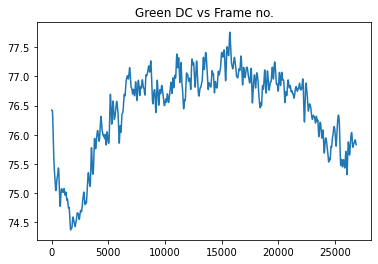

In [30]:
LH_g_DC = DC(LH_g_ms) + np.mean(LH_g)
plt.plot(range(len(LH_g_DC)),LH_g_DC)
plt.title('Green DC vs Frame no.')

Text(0.5, 1.0, 'Red AC/DC vs Frame no.')

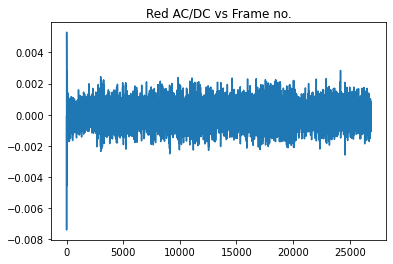

In [31]:
LH_r_AC_DC = np.divide(LH_r_AC,LH_r_DC)
LH_r_AC_DC = np.divide(LH_r_AC,np.mean(LH_r_DC))
plt.plot(range(len(LH_r_AC_DC)),LH_r_AC_DC) 
#looks reasonable? 
np.min(np.abs(LH_r_AC)) #doesn't run into divide by zero issue here

plt.title('Red AC/DC vs Frame no.')

Text(0.5, 1.0, 'Green AC/DC vs Frame no.')

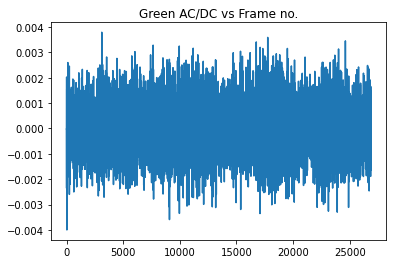

In [32]:
LH_g_AC_DC = np.divide(LH_g_AC,LH_g_DC)
LH_g_AC_DC = np.divide(LH_g_AC,np.mean(LH_g_DC))
plt.plot(range(len(LH_g_AC_DC)),LH_g_AC_DC) 
#looks reasonable? 
np.min(np.abs(LH_g_AC)) #doesn't run into divide by zero issue here


plt.title('Green AC/DC vs Frame no.')

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


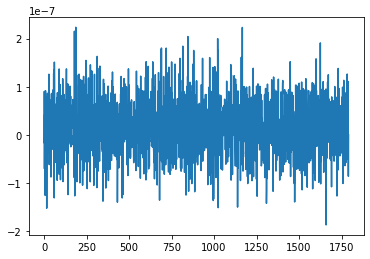

In [33]:
estimate_LH,GTs = process(15,15, LH_r, LH_g)
plt.plot(estimate_LH)

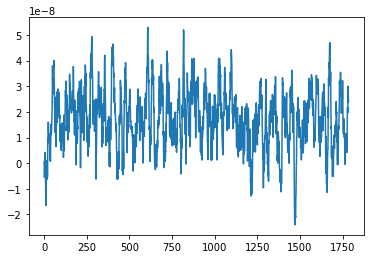

In [34]:
#Moving average the signal with 15 frame window
estimate_LH_avg = scipy.signal.convolve(estimate_LH,np.ones(15)/15,'same')
plt.plot(estimate_LH_avg)

In [35]:


def fitting_bothhands(estimate_RH, estimate_LH, GT, order):

    n = order #polynomial order
    coef= np.polyfit(estimate_RH,GT,n)
    fit_estimate_RH = 0
    fit_estimate_LH = 0
    for i in range(n+1):
        fit_estimate_RH = fit_estimate_RH + coef[i]*np.power(estimate_RH,n-i)
        fit_estimate_LH = fit_estimate_LH + coef[i]*np.power(estimate_LH,n-i)
    return fit_estimate_RH,fit_estimate_LH

estimates_LH_cut = np.asarray(estimate_LH_avg[:-20])
fit_estimate_RH,fit_estimate_LH = fitting_bothhands(estimates_RH_cut,estimates_LH_cut, GTs_cut, 1)


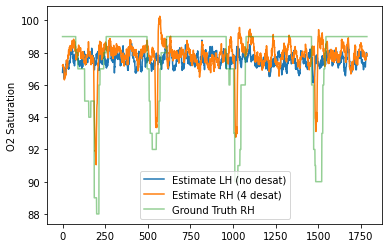

In [43]:
plt.plot(fit_estimate_LH)
plt.plot(fit_estimate_RH)
plt.plot(GTs_cut,alpha = 0.5)

# plt.xlabel('half seconds',fontsize = 30)
plt.ylabel('O2 Saturation')

plt.legend(['Estimate LH (no desat)','Estimate RH (4 desat)','Ground Truth RH'])

In [37]:
print(np.corrcoef(fit_estimate_RH,GTs_cut))
print(np.sqrt(np.mean((fit_estimate_RH-GTs_cut)**2)/len(fit_estimate_RH)))

[[1.        0.3940659]
 [0.3940659 1.       ]]
0.05495299983743198


In [38]:
list(range(5))

[0, 1, 2, 3, 4]

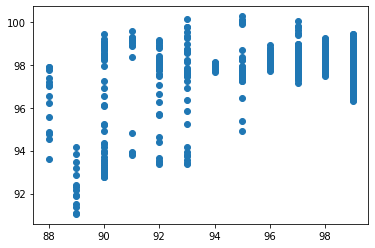

In [39]:
plt.scatter(GTs_cut,fit_estimate_RH)